# Data Analysis for Master Thesis Project

## Environment Preparation

In [119]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import data_prep
import survey_data
from functools import reduce
import pingouin as pg

## Preprocessing

In the preprocessing the datafile wich is created automatically from PsychPy is transformed into a clean format so that analysis can be done. For that reason all available files are read and the prepare data function from the data_prep file is called. The practice trials are sorted out and a new index is created without holding the practice trial.
The questionnaire data is preprocessed in a separate step by calling the survey_data function from the survey_data file.
Both preprocessed data files are stored as csv files.

In [120]:
# List all data files which should be preprocessed

data_files = ['3157.csv',
              '3430.csv',
              '4489.csv',
              '6007.csv',
              '6070.csv',
              '6988.csv',
              '238542.csv',
              '393192.csv',
              '411686.csv',
              '649043.csv',
              '965200.csv',
              '633326.csv',
              '982078.csv',
              '990857.csv',
              '886787.csv',
              '852408.csv',
              '470738.csv',
              '020622.csv',
              '874910.csv',
              '828938.csv',
              '417785.csv',
              '153234.csv',
              '106121.csv',
              '8050.csv'
              ]

In [121]:
# Preprocess data from experiment
data = data_prep.prepare_data(data_files)

/Users/anja/Documents/GitHub/master_thesis/data_prep.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_df = pd.concat(dfs, ignore_index=True)


In [122]:
# Detele practice trials and create practice subset
practice_trials = data[data['block'] == 'Test']
data = data[data['block'] != 'Test']

In [123]:
# Create trial index per participant (after test trials were deleted!)
data['trial_index_within_participant'] = data.groupby('participant').cumcount() + 1

In [124]:
# Preprocess data from pavlovia surveys (questionnaire answers)
survey_data = survey_data.survey_data(data_files)

In [125]:
# Store preprocessed data in csv
data.to_csv('/Users/anja/Desktop/data_mt/data_preprocessed.csv', index=False)
survey_data.to_csv('/Users/anja/Desktop/data_mt/data_survey.csv', index=False)

## Demographic Data

In this section the demographic data from the survey dataset is analysed to find out how handedness, gender and age are distributed among participants.

In [126]:
# Summarize handedness
survey_data['handedness'].describe()

count        24
unique        2
top       right
freq         23
Name: handedness, dtype: object

In [127]:
# Summarize age
survey_data['age'].describe()

count    24.000000
mean     27.041667
std       5.488955
min      20.000000
25%      24.000000
50%      25.000000
75%      30.000000
max      44.000000
Name: age, dtype: float64

In [128]:
# Summarize gender
survey_data['gender'].describe()

count         24
unique         3
top       female
freq          16
Name: gender, dtype: object

## Error rates
Since participants have trails where they have been asked to respond faster or reiterate their response because they did not confirm correctly, we'll need to decide which of those trials to keep for analysis and which to sort out. In order to do so, error rates of participants are analysed.

In [129]:
# Error rates per participant
# Add bool column for error in decision
data['error_in_decision'] = data[['bool_slow_color_choice_or_confirm', 'bool_wrong_color_confirm']].any(axis=1).astype(int)

# Add bool column for error in owner confirm
data['error_in_outcome_attribution'] = data[['bool_slow_owner_confirm', 'bool_wrong_owner_confirm']].any(axis=1).astype(int)

# Group by participant and sum the errors
errors_per_participant = data.groupby('participant')[['error_in_decision', 'error_in_outcome_attribution']].sum().reset_index()

# Calculate ratios
total_trials = 384
errors_per_participant['error_in_decision_ratio'] = round(((errors_per_participant['error_in_decision'] / total_trials) * 100),2)
errors_per_participant['error_in_outcome_attribution_ratio'] = round(((errors_per_participant['error_in_outcome_attribution'] / total_trials) *100),2)

In [130]:
errors_per_participant.describe()

,participant,error_in_decision,error_in_outcome_attribution,error_in_decision_ratio,error_in_outcome_attribution_ratio
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,413069.083333,12.708333,31.583333,3.308333,8.226250
std,383538.295380,9.648064,17.123380,2.513722,4.459915
min,3157.000000,1.000000,11.000000,0.260000,2.860000
25%,7784.500000,6.000000,17.750000,1.560000,4.625000
50%,402439.000000,9.000000,29.000000,2.340000,7.550000
75%,834805.500000,18.250000,41.250000,4.755000,10.745000
max,990857.000000,37.000000,69.000000,9.640000,17.970000


In [131]:
# Clean from rows where response was too slow or wrong 
#TODO: discuss what we want to sort out? Change data_n into data when decided!
data_n = data[(data['bool_slow_color_choice_or_confirm'] == False) & 
            (data['bool_wrong_color_confirm'] == False) & 
            (data['bool_slow_owner_confirm'] == False) & 
            (data['bool_wrong_owner_confirm'] == False)]

# Store cleaned data in csv
data_n.to_csv('/Users/anja/Desktop/data_mt/data_cleaned.csv', index=False)

## Analysis

### Normal Distribution

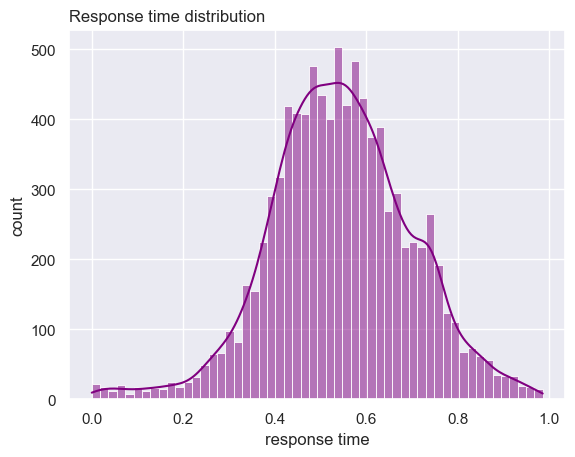

In [132]:
# Histogram of all response times
sns.set_theme(style="darkgrid")

sns.histplot(data=data, x="owner_confirm_rt", color="purple", kde=True)

plt.title('Response time distribution', loc='left')
plt.xlabel('response time')
plt.ylabel('count')

plt.show()

### Confirm previous results from Abubshait et. al

Are participants faster when confirming give or when confirming keep?

1) In original study participants were faster when outcome was kept by themselves, slower when outcome was given to Cozmo (no matter what outcome value)

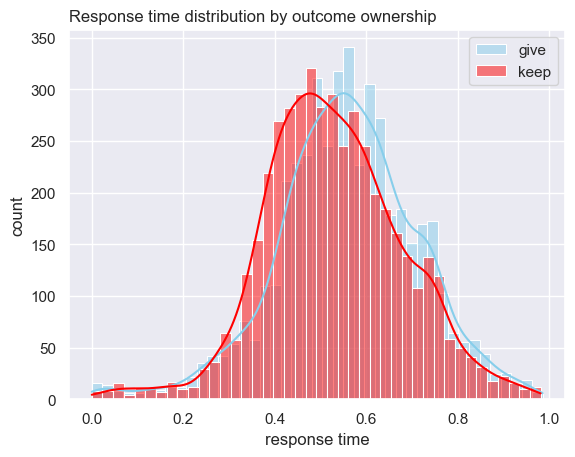

In [133]:
# Histogram of response times
# TODO: mirror https://python-graph-gallery.com/density-mirror/
sns.set_theme(style="darkgrid")

sns.histplot(data=data[data['owner_confirm_keys'] == 'g'], x="owner_confirm_rt", color="skyblue", label="give", kde=True)
sns.histplot(data=data[data['owner_confirm_keys'] == 'k'], x="owner_confirm_rt", color="red", label="keep", kde=True)

plt.title('Response time distribution by outcome ownership', loc='left')
plt.xlabel('response time')
plt.ylabel('count')

plt.legend() 
plt.show()

2. In original study when the outcome was kept by oneself it was easier to keep wins and harder to keep losses. This was only found for the participant as outcome owner, not for the robot as outcome owner. This could mean that participants are less invested / interested in the outcomes of Cozmo. There is a differentiation between Cozmo and oneself.

In [134]:
# Group by owner, value
data.groupby(['owner', 'value']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,owner,value,average_response_time,median_response_time
0,cozmo,lose,0.556990,0.55700
1,cozmo,win,0.558910,0.55900
2,you,lose,0.542724,0.53500
3,you,win,0.515993,0.50295


3. In original study participants were faster when the outcome value was winning, no matter which outcome owner it was.

--> Since we already know that giving is harder (takes longer) than keeping, this is probalby anyways driven by the outcome owner = "you" condition

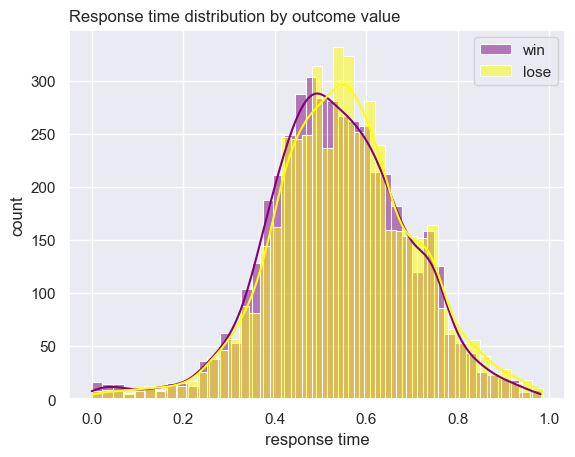

In [135]:
# Histogram of response times
sns.set_theme(style="darkgrid")

sns.histplot(data=data[data['value'] == 'win'], x="owner_confirm_rt", color="purple", label="win", kde=True)
sns.histplot(data=data[data['value'] == 'lose'], x="owner_confirm_rt", color="yellow", label="lose", kde=True)

plt.title('Response time distribution by outcome value', loc='left')
plt.xlabel('response time')
plt.ylabel('count')

plt.legend() 
plt.show()

4. Elevated response conflict when giving a win (as compared to give a loss) to Cozmo

One can see this in the differences between giving and keeping for “Win” outcomes (difference is larger) compared to the difference between keeping and giving “Lose” outcomes (smaller difference in reponse times). 

"Since we know that giving in general is harder than keeping, the especially hard condition is to give a win"

In [136]:
data.groupby(['value', 'owner']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,value,owner,average_response_time,median_response_time
0,lose,cozmo,0.556990,0.55700
1,lose,you,0.542724,0.53500
2,win,cozmo,0.558910,0.55900
3,win,you,0.515993,0.50295


#### Re-Examine ANOVA

To measure cognitive conflict, participants' reaction times (RTs) to confirm the Keep-Give assignment were analyzed. RTs were averaged for correct trials that were within +/3SD of the overall mean. Averaged RTs were subjected to a 2x2 repeated measures ANOVA with Assignment (Keep vs. Give) and Outcome (Win vs. Lose) as within-factors. Analyses were conducted using R.

--> what was averaged? for each participant or for condition set?

--> sort ort sinlge trials were answer was wrong or data of participant?

--> other methods in python are statsmodels package, or pyvttbl

--> F(1,149) oder mit weniger Datensätzen F(1,15)

--> original paper also did following t tests

In [137]:
anova = pg.anova(dv='owner_confirm_rt', between=['value', 'owner'], data=data,
             detailed=True)

print(anova)

          Source          SS      DF        MS          F         p-unc  \
0          value    0.354621     1.0  0.354621  15.142788  1.003805e-04   
1          owner    1.860535     1.0  1.860535  79.447345  5.897202e-19   
2  value * owner    0.471965     1.0  0.471965  20.153520  7.233718e-06   
3       Residual  215.730906  9212.0  0.023418        NaN           NaN   

        np2  
0  0.001641  
1  0.008551  
2  0.002183  
3       NaN  


### Boxplot per condition group

Text(0, 0.5, 'response time')

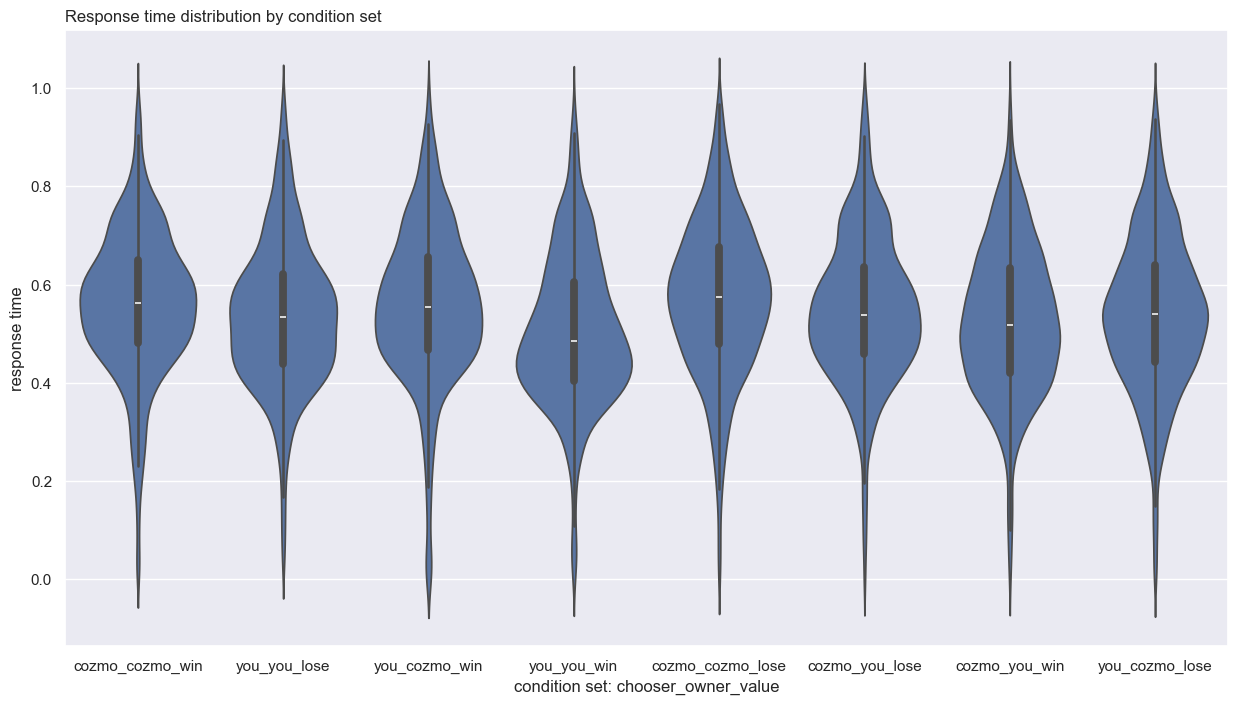

In [138]:
# Reaction time per condition group 
# https://python-graph-gallery.com/39-hidden-data-under-boxplot/
# sns.boxplot( x=data["identifier_chooser_owner_value_corr"], y=data["owner_confirm_rt"] )
plt.figure(figsize=(15, 8)) 
sns.violinplot( x=data["identifier_chooser_owner_value_corr"], y=data["owner_confirm_rt"] )

plt.title('Response time distribution by condition set', loc='left')
plt.xlabel('condition set: chooser_owner_value')
plt.ylabel('response time')


Since the original study found that any outcome given to Cozmo leads to heightened conflict, we assume that decision agency could have a positive shaping effect here. Meaning that when the robot has the agency in decision it makes it again easier to give any outcome because participants are overall less invested.

In [139]:
# Group by chooser, owner
data.groupby(['chooser','owner']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,chooser,owner,average_response_time,median_response_time
0,cozmo,cozmo,0.566680,0.56735
1,cozmo,you,0.537546,0.53245
2,you,cozmo,0.549120,0.54660
3,you,you,0.520336,0.50875


In [140]:
# Group by owner, chooser, value
data.groupby(['chooser','owner', 'value']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,chooser,owner,value,average_response_time,median_response_time
0,cozmo,cozmo,lose,0.572778,0.57375
1,cozmo,cozmo,win,0.560052,0.56225
2,cozmo,you,lose,0.549287,0.53840
3,cozmo,you,win,0.526744,0.51800
4,you,cozmo,lose,0.541511,0.53940
5,you,cozmo,win,0.557743,0.55465
6,you,you,lose,0.536301,0.53320
7,you,you,win,0.505023,0.48575


### Response time over duration of experiment

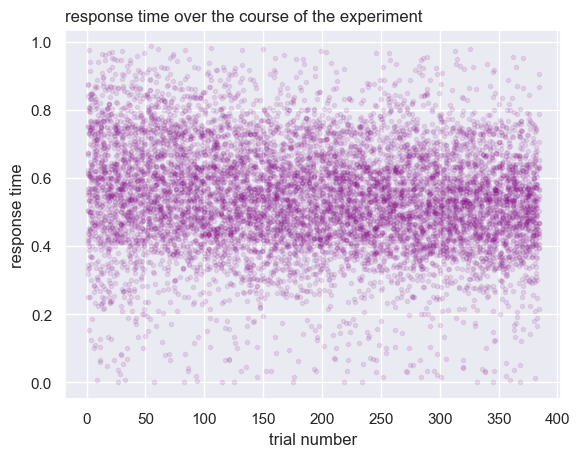

In [141]:
# how does reaction time develope over time? learning effects? do get people faster? 
# https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/ 

# Plot with transparency
plt.plot( data["trial_index_within_participant"], data["owner_confirm_rt"], data=data, linestyle='', marker='o', markersize=3, alpha=0.1, color="purple")
 
# Titles
plt.xlabel('trial number')
plt.ylabel('response time')
plt.title('response time over the course of the experiment', loc='left')
plt.show()

### Analysis related to handedness

Is there any relation between the handedness of participants and their choices of colors or response times?

In [142]:
# Do people prefer one choice when deciding for color? E.g., do right handed people rather choose with 'k' than 'g' when selecting one color
choice_loaction_by_handedness = data[data['chooser'] == 'you']
choice_loaction_by_handedness = choice_loaction_by_handedness.groupby(['participant', 'choice_location']).agg(
    choice_location_count=('choice_location', 'count')).reset_index()

# Merge handedenss of participants
choice_loaction_by_handedness = choice_loaction_by_handedness.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

In [143]:
# Is the reaction time of outcome attribution related to handedness and answer key? E.g., are right handed people faster responding to 'keep' than 'give'
rt_by_confirm_keys = data.groupby(['participant', 'owner_confirm_keys']).agg(
    average_response_time=('owner_confirm_rt', 'mean'),
    median_response_time=('owner_confirm_rt', 'median')).reset_index()

# Merge handedenss of participants
rt_by_confirm_keys = rt_by_confirm_keys.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

In [144]:
rt_by_confirm_keys.groupby(['handedness','owner_confirm_keys']).agg(average_response_time=('average_response_time', 'mean')).reset_index()

,handedness,owner_confirm_keys,average_response_time
0,other,g,0.456535
1,other,k,0.451541
2,right,g,0.562307
3,right,k,0.532306


### Extra

#### Repition driven response time

Are particpant faster when two times using the same key? e.g. first choose right square or confirm right square and proceed with keep (which is again the right key)?

In [145]:
# TODO: it would probably make sense to sort out wrong answers

# Select subset from data with only relevant columns
subset = data.loc[:, ['participant', 'trial_index_within_participant', 'choice_location', 'owner_confirm_keys', 'owner_confirm_rt']].copy()

# Create identifier column: location_decision_owner_same = True / False
subset.loc[:, 'location_decision_owner_same'] = (
    ((subset['choice_location'] == 'left') & (subset['owner_confirm_keys'] == 'g')) |
    ((subset['choice_location'] == 'right') & (subset['owner_confirm_keys'] == 'k'))
)

subset = subset.groupby(['participant','location_decision_owner_same']).agg(average_response_time=('owner_confirm_rt', 'mean'))

# Aggregate owner_confirm_rt
subset.groupby(['location_decision_owner_same']).agg(average_response_time=('average_response_time', 'mean'))

,average_response_time
location_decision_owner_same,
False,0.545791
True,0.541065


#### Balance dependent response time

Is it easier to give when cozmo anyways has a lower balance than have?

In [146]:
#Als variable anschauen wie viel gewinn oder Verlust Cozmo schon hatte.

#### "Win-stay lose-shift"-Verhalten

Normalerweise geht man davon aus, dass Leute nach einem Win mit höherer Wahrscheinlichkeit das gleiche Item nochmal wählen (bzw. das andere nach einem Loss). Hier wäre es interessant, ob Leute stärkeres "win-stay lose-shift" Verhalten zeigen, wen die Wahl im letzten Trial von ihnen selbst getroffen wurden, anstatt von dem Roboter (d.h. ob sie die Outcomes ihrer eigenen Entscheidungen eher informativ finden)

In [147]:
# Analysis idea Jakob had and was mentioning in his e-mail